In [1]:
import os

import torch

from src.agents import DiscreteActorCritic
from src.networks import DiscreteActorCriticNetwork
from src.pv_env import History, PVEnvDiscrete
from src.reward import RewardDeltaPower

PV_PARAMS_PATH = os.path.join("parameters", "01_pvarray.json")
WEATHER_TRAIN_PATH = os.path.join("data", "weather_sim.csv")
WEATHER_TEST_PATH = os.path.join("data", "weather_real.csv")
PVARRAY_CKP_PATH = os.path.join('data', '01_pvarray_iv.json')
AGENT_CKP_PATH = os.path.join("models", "02_mppt_ac.tar")
LEARNING_RATE = 0.01
ENTROPY_BETA = 0.01
GAMMA = 0.9
N_STEPS = 1
BATCH_SIZE = 16

In [2]:
env = PVEnvDiscrete.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(1, 0.9),
    actions=[-1, -0.1, 0, 0.1, 1],
)
test_env = PVEnvDiscrete.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(2, 1),
    actions=[-1, -0.1, 0, 0.1, 1],
)
device = torch.device("cpu")
net = DiscreteActorCriticNetwork(
    input_size=env.observation_space.shape[0], n_actions=env.action_space.n
).to(device)
agent = DiscreteActorCritic(
    env=env,
    test_env=test_env,
    net=net,
    device=device,
    gamma=GAMMA,
    beta_entropy=ENTROPY_BETA,
    lr=LEARNING_RATE,
    n_steps=N_STEPS,
    batch_size=BATCH_SIZE,
    # chk_path=AGENT_CKP_PATH,
    chk_path=None,
)

INFO 2020-11-15 21:32:07,295 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-15 21:32:07,296 Starting MATLAB engine . . .
INFO 2020-11-15 21:32:12,009 MATLAB engine initializated.
INFO 2020-11-15 21:32:31,991 Model loaded succesfully.
INFO 2020-11-15 21:32:31,999 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-15 21:32:32,000 Reading data\weather_sim.csv . . .
INFO 2020-11-15 21:32:32,012 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-15 21:32:32,013 Starting MATLAB engine . . .
INFO 2020-11-15 21:32:37,630 MATLAB engine initializated.
INFO 2020-11-15 21:32:57,232 Model loaded succesfully.
INFO 2020-11-15 21:32:57,239 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-15 21:32:57,242 Reading data\weather_sim.csv . . .


In [3]:
agent.train(steps=5000, verbose_every=100, save_every=0)

  2%|▏         | 107/5000 [00:02<02:14, 36.46it/s]
 100: loss=0.409354,  mean reward=-376.54,  steps/ep=833,  episodes=1
  4%|▍         | 207/5000 [00:05<01:55, 41.48it/s]
 200: loss=0.977231,  mean reward=-531.43,  steps/ep=833,  episodes=3
  6%|▌         | 305/5000 [00:07<01:34, 49.67it/s]
 300: loss=1.192869,  mean reward=-284.20,  steps/ep=833,  episodes=5
  8%|▊         | 404/5000 [00:09<01:31, 50.35it/s]
 400: loss=0.128937,  mean reward=-169.27,  steps/ep=833,  episodes=7
 10%|█         | 508/5000 [00:11<01:32, 48.53it/s]
 500: loss=1.446481,  mean reward=-104.68,  steps/ep=833,  episodes=9
 12%|█▏        | 609/5000 [00:13<01:28, 49.42it/s]
 600: loss=0.429158,  mean reward=-65.52,  steps/ep=833,  episodes=11
 14%|█▍        | 705/5000 [00:15<01:25, 50.00it/s]
 700: loss=0.031134,  mean reward=-37.01,  steps/ep=833,  episodes=13
 16%|█▌        | 807/5000 [00:17<01:24, 49.56it/s]
 800: loss=0.950096,  mean reward=-16.60,  steps/ep=833,  episodes=15
 18%|█▊        | 909/5000 [00:19

INFO 2020-11-15 21:36:16,624 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:00<00:00, 944.71it/s]
INFO 2020-11-15 21:36:17,510 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 166812.09it/s]


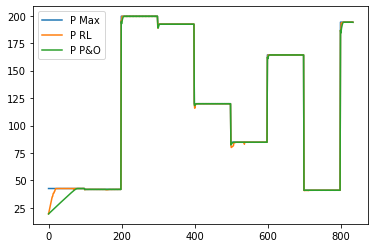

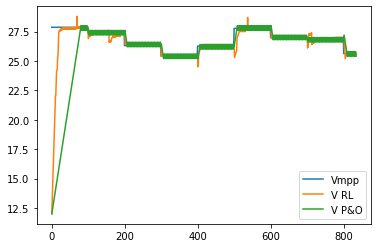

INFO 2020-11-15 21:36:18,091 PO Efficiency=97.44529552878711
INFO 2020-11-15 21:36:18,092 RL Efficiency=99.31166882212213


In [18]:
agent.exp_train_source.play_episode()
env.render_vs_true(po=True)

INFO 2020-11-15 21:41:45,436 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 796.52it/s]
INFO 2020-11-15 21:41:46,486 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 277998.06it/s]


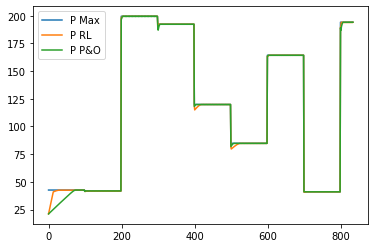

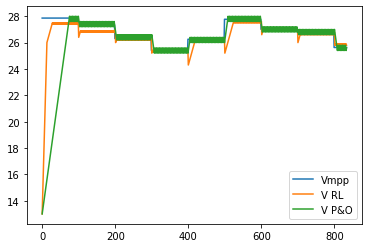

INFO 2020-11-15 21:41:47,089 PO Efficiency=97.77582699189402
INFO 2020-11-15 21:41:47,090 RL Efficiency=99.28130570808722


In [31]:
agent.exp_test_source.play_episode()
test_env.render_vs_true(po=True)

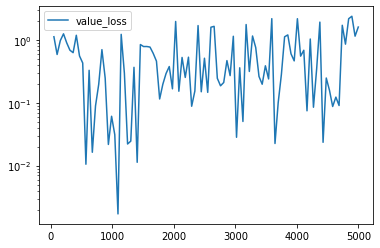

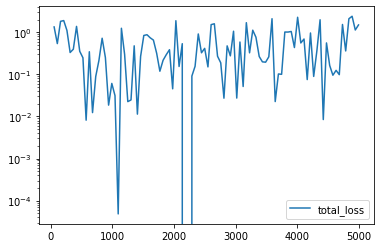

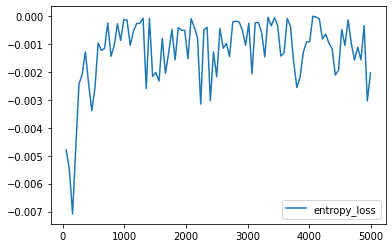

In [29]:
agent.plot_performance(['value_loss', 'total_loss', 'entropy_loss'])